# Evaluate CNN model on different metrics using the m6A validation data. 

In [157]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import pandas as pd
import requests
import io


class M6ANet(torch.nn.Module):
    def __init__(self, input_size=7, n_layers=3, sec_last_layer_size=25, last_layer_size=5,
                 output_shape=2):
        """
        Constructor for the M6ANet, a CNN model for m6A calling.
        :param input_size: int, number of channels in the data, currently 6, 4 for nucleotide identity, one for inter-
                                pulse distance and one for pulse width.
        :param n_layers: int, number of layers in the CNN model.
        :param sec_last_layer_size: int, size of the second last dense layer.
        :param last_layer_size: int, size of the last dense layer.
        :param output_shape: int, number of outputs, two in our case, m6A or not.
        """
        super(M6ANet, self).__init__()

        self.n_layers = n_layers

        # Assign a name to the model
        self.name = f"m6Anet_all.{n_layers}"

        # Three convolution layers with ReLU activation
        self.conv_1 = torch.nn.Conv1d(input_size, 30, kernel_size=5, stride=1)

        self.conv_2 = torch.nn.Conv1d(30, 10, kernel_size=5, stride=1)

        self.conv_3 = torch.nn.Conv1d(10, 5, kernel_size=3, stride=1)

        # a dense layer with ReLU activation
        self.linear = torch.nn.Linear(sec_last_layer_size, last_layer_size)

        # an output dense layer with no activation
        self.label = torch.nn.Linear(last_layer_size, output_shape)

        # Loss function
        self.cross_entropy_loss = torch.nn.BCELoss(reduction='mean')

    def forward(self, X):
        """
        Forward function to go from input to output
        of the model.
        :param X: Tensor, input to the model.
        :return: y: tensor, output from the model.
        """
        # Three convolutional layers with ReLU activation
        X = torch.nn.ReLU()(self.conv_1(X))
        X = torch.nn.ReLU()(self.conv_2(X))
        X = torch.nn.ReLU()(self.conv_3(X))
        # Condense 2D shape to 1D
        X = torch.flatten(X, 1)
        # Dense layer with ReLU activation
        X = torch.nn.ReLU()(self.linear(X))
        # Output layer
        y = torch.nn.Softmax(dim=1)(self.label(X))
        return y

    def predict(self, X, batch_size=64, device='cpu'):
        """
        Predict function to generate M6ANet model predictions.
        :param X: tensor, input data
        :param batch_size: int, batch size for generating predictions in.
        :return: m6a_labels: tensor, predictions
        """
        with torch.no_grad():
            # Get batch start indices
            starts = np.arange(0, X.shape[0], batch_size)
            # Get batch end indices
            ends = starts + batch_size
            # m6a labels
            m6a_labels = []
            # Get predictions for every batch
            for start, end in zip(starts, ends):
                X_batch = X[start:end].to(device)
                # Run the data through the forward
                # function to generate label predictions
                m6a_labels_ = self(X_batch)
                # Move the label predictions to the CPU
                m6a_labels_ = m6a_labels_.cpu()
                # Append to the list of all labels
                m6a_labels.append(m6a_labels_)
            # Make one list of all labels
            m6a_labels = torch.cat(m6a_labels)
            return m6a_labels

    def fit_generator(self, training_data, model_optimizer,
                      X_valid=None, y_valid=None, max_epochs=10,
                      verbose=True, validation_iter=1000, device='cpu'):
        """

        :param training_data: torch.DataLoader, training data generator
        :param model_optimizer: torch.Optimizer, An optimizer to training our model
        :param X_valid: numpy array, validation features
        :param y_valid: numpy array, validation labels
        :param max_epochs: int, maximum epochs to run the model for
        :param verbose: bool, whether to compute validation stats
        :param validation_iter: int, After how many iterations should we compute validation stats.
        :param device: str, GPU versus CPU, defaults to CPU
        :return: None
        """
        # Convert validation data into tensors
        X_valid = torch.tensor(X_valid).float()
        y_valid = torch.tensor(y_valid).float()
        X_valid = X_valid.to(device)
        y_valid = y_valid.to(device)

        best_loss = float("inf")
        for epoch in range(max_epochs):
            # to log cross-entropy loss to average over batches
            avg_train_loss = 0
            avg_train_iter = 0
            iteration = 0
            for data in training_data:
                # Get features and label batch
                X, y = data
                # Convert them to float
                X = X.float()
                y = y.float()
                X, y = X.to(device), y.to(device)

                # Clear the optimizer and set the model to training mode
                model_optimizer.zero_grad()
                self.train()

                # Run forward pass
                m6a_labels = self.forward(X)

                # Calculate the cross entropy loss
                cross_entropy_loss = self.cross_entropy_loss(m6a_labels, y)

                # Extract the cross entropy loss for logging
                cross_entropy_loss_ = cross_entropy_loss.item()

                # Do the back propagation
                cross_entropy_loss.backward()
                model_optimizer.step()

                # log loss to average over training batches
                avg_train_loss += cross_entropy_loss_
                avg_train_iter += 1

                # If verbose is true and current iteration is a validation iteration
                # compute validation stats.
                if verbose and iteration % validation_iter == 0:
                    with torch.no_grad():
                        # Set the model to evaluation mode
                        self.eval()
                        # Convert one hot encoded labels to number based labels ([0, 1] -> 1, [1, 0] -> 0)
                        y_valid_metric = torch.argmax(y_valid, dim=1).int()
                        # Compute the predictions for the validation set
                        valid_preds = self.predict(X_valid, device=device)
                        # Move predictions to CPU/GPU
                        valid_preds = valid_preds.to(device)
                        # Convert one hot encoded predictions to number based labels ([0, 1] -> 1, [1, 0] -> 0)
                        pred_valid_metric = torch.argmax(valid_preds, dim=1).int()
                        # compute cross_entropy loss for the validation set.
                        cross_entropy_loss = self.cross_entropy_loss(valid_preds, y_valid)
                        # Extract the validation loss
                        valid_loss = cross_entropy_loss.item()
                        # Compute AUROC
                        sklearn_rocauc = roc_auc_score(y_valid.cpu().numpy(), valid_preds.cpu().numpy(),
                                                       average='micro')
                        # Compute AUPR/Average precision
                        sklearn_ap = average_precision_score(y_valid.cpu().numpy(), valid_preds.cpu().numpy(),
                                                             average='micro')
                        # Compute accuracy
                        sklearn_acc = accuracy_score(y_valid_metric.cpu().numpy(), pred_valid_metric.cpu().numpy())

                        print(f"Epoch {epoch}, iteration {iteration}, train loss: {(avg_train_loss / avg_train_iter):4.4f}, validation loss: {valid_loss:4.4f}")

                        print(f"Validation iteration {iteration}, AUPR: {sklearn_ap}, Accuracy: {sklearn_acc}, AUROC: {sklearn_rocauc}")

                        if valid_loss < best_loss:
                            torch.save(self, "{}.torch".format(self.name))
                            best_loss = valid_loss

                        avg_train_loss = 0
                        avg_train_iter = 0

                iteration += 1

        torch.save(self, "{}.final.torch".format(self.name))

In [158]:
data_path = "../data/m6A_train_more_large.npz"

train_val_data = np.load(data_path, allow_pickle=True)

# Get the dictionary from the containing relevant data
train_val_data = train_val_data['save_data_dict'][()]

# Load training and validation features and labels
X_train = train_val_data['X_train']
y_train = train_val_data['y_train']
X_val = train_val_data['X_val']
y_val = train_val_data['y_val']
val_subreads = train_val_data['val_subread_counts']


m6a_model = torch.load("models/m6ANet_more_large.3.best.torch", map_location=torch.device('cpu'))

X_val = torch.Tensor(X_val)
val_pred = m6a_model.predict(X_val, device='cpu').detach().numpy()

read: 1
AUC-ROC: 0.893
read: 2
AUC-ROC: 0.900
read: 3
AUC-ROC: 0.908
read: 4
AUC-ROC: 0.916
read: 5
AUC-ROC: 0.922
read: 6
AUC-ROC: 0.928


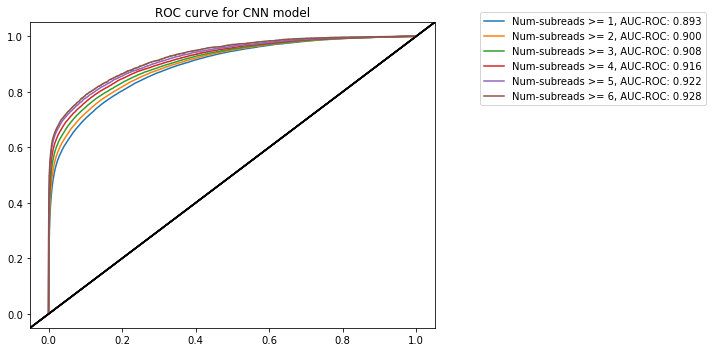

In [176]:
from sklearn.metrics import (confusion_matrix,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             balanced_accuracy_score,
                             matthews_corrcoef,
                             roc_auc_score,
                             average_precision_score,
                             roc_curve,
                             precision_recall_curve
                             )
plt.figure(figsize=(10,5))
for read in range(1, 7, 1):
    print(f"read: {read}")
    subread_thr = np.where(val_subreads >= read)[0]
    y_pred = val_pred[subread_thr, 0]
    y_obs = y_val[subread_thr, 0]

    fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
    #for i in range(len(fpr)):
    #    if fpr[i] <= 0.05 and fpr[i] >= 0.0498:
    #        print(f"fpr: {fpr[i]}, tpr: {tpr[i]}, threshold: {thresholds[i]}")
    
    print(f"AUC-ROC: {metrics.auc(fpr, tpr):.03f}")
    plt.plot(fpr, tpr, label=f"Num-subreads >= {read}, AUC-ROC: {metrics.auc(fpr, tpr):.03f}")
    plt.axline([0,0], slope=1, c="black")
    #plt.text(.6, .2, f"AUC-ROC: {metrics.auc(fpr, tpr):.03f}") 
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title("ROC curve for CNN model")
    plt.tight_layout()
    plt.savefig("roc_cnn.png")
    plt.plot()

In [132]:
# Get tpr, fpr, tnr, fnr
tn, fp, fn, tp = metrics.confusion_matrix(y_obs, y_pred>0.0956).ravel()
print(f"tn: {tn}, fp: {fp}, fn:{fn}, tp:{tp}")

tpr = tp/(tp+fn)

fpr = fp/(fp+tn)

tnr = tn/(tn+fp)

fnr = fn/(fn+tp)

print(f"tpr: {tpr}")
print(f"fpr: {fpr}")
print(f"tnr: {tnr}")
print(f"fnr: {fnr}")

confusion_raw = metrics.confusion_matrix(y_obs, y_pred>0.2087)
print(f"confusion_raw: {confusion_raw}")
confusion_percent = np.transpose(confusion_raw.transpose()/confusion_raw.sum(axis=1)*100)
confusion_raw, confusion_percent, np.array([["TN", "FP"], ["FN", "TP"]] )

tn: 84834, fp: 2389, fn:1887, tp:3949
tpr: 0.6766620973269363
fpr: 0.02738956467904108
tnr: 0.9726104353209589
fnr: 0.3233379026730637
confusion_raw: [[86632   591]
 [ 2407  3429]]


(array([[86632,   591],
        [ 2407,  3429]]),
 array([[99.32242642,  0.67757358],
        [41.24400274, 58.75599726]]),
 array([['TN', 'FP'],
        ['FN', 'TP']], dtype='<U2'))

Text(0.6, 0.2, 'AUC-PR: 0.731')

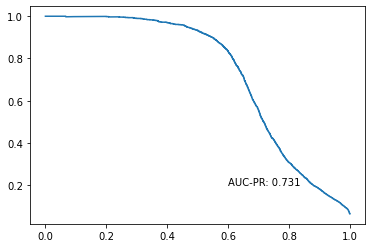

In [133]:
precision, recall, thresholds = metrics.precision_recall_curve(y_obs, y_pred, pos_label=1)

plt.plot(recall, precision)
plt.text(.6, .2, f"AUC-PR: {metrics.average_precision_score(y_obs, y_pred, average='micro'):.03f}") 

In [160]:
import xgboost as xgb 

bst2 = xgb.Booster({'nthread': 4})  # init model
bst2.load_model('models/xgboost.large.json')  # load data

X_val_2d = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])

dval = xgb.DMatrix(X_val_2d)
ypred_xgb = bst2.predict(dval)

read: 1
AUC-ROC: 0.892
read: 2
AUC-ROC: 0.899
read: 3
AUC-ROC: 0.907
read: 4
AUC-ROC: 0.915
read: 5
AUC-ROC: 0.922
read: 6
AUC-ROC: 0.927


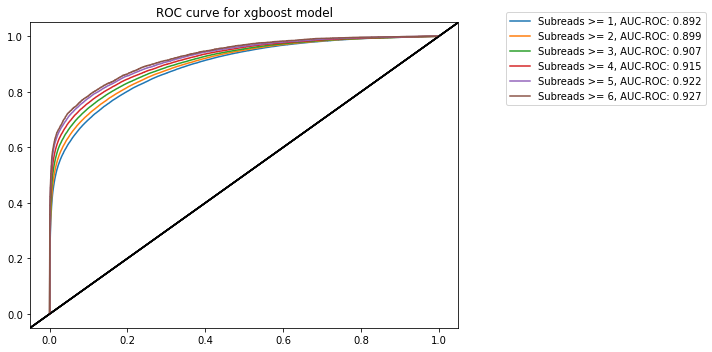

In [175]:
plt.figure(figsize=(10,5))
for read in range(1, 7, 1):
    print(f"read: {read}")
    subread_thr = np.where(val_subreads >= read)[0]
    y_pred = ypred_xgb[subread_thr]
    #print("y_pred: ", y_pred, np.min(y_pred), np.max(y_pred))
    y_obs = y_val[subread_thr, 0]
    
    #print("y_obs: ", y_obs, np.min(y_obs), np.max(y_obs))

    fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
    #for i in range(len(fpr)):
    #    if fpr[i] <= 0.05 and fpr[i] >= 0.0498:
    #        print(f"fpr: {fpr[i]}, tpr: {tpr[i]}, threshold: {thresholds[i]}")
    
    print(f"AUC-ROC: {metrics.auc(fpr, tpr):.03f}")
    plt.plot(fpr, tpr, label=f"Subreads >= {read}, AUC-ROC: {metrics.auc(fpr, tpr):.03f}")
    plt.axline([0,0], slope=1, c="black")
    #plt.text(.6, .2, f"AUC-ROC: {metrics.auc(fpr, tpr):.03f}") 
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title("ROC curve for xgboost model")
    plt.tight_layout()
    plt.savefig("roc_xgboost.png")
    plt.plot()

In [130]:
# Get tpr, fpr, tnr, fnr
tn, fp, fn, tp = metrics.confusion_matrix(y_obs, y_pred>0.0956).ravel()
print(f"tn: {tn}, fp: {fp}, fn:{fn}, tp:{tp}")

tpr = tp/(tp+fn)

fpr = fp/(fp+tn)

tnr = tn/(tn+fp)

fnr = fn/(fn+tp)

print(f"tpr: {tpr}")
print(f"fpr: {fpr}")
print(f"tnr: {tnr}")
print(f"fnr: {fnr}")

confusion_raw = metrics.confusion_matrix(y_obs, y_pred>0.2087)
print(f"confusion_raw: {confusion_raw}")
confusion_percent = np.transpose(confusion_raw.transpose()/confusion_raw.sum(axis=1)*100)
confusion_raw, confusion_percent, np.array([["TN", "FP"], ["FN", "TP"]] )

tn: 82881, fp: 4342, fn:1600, tp:4236
tpr: 0.7258396161754627
fpr: 0.04978044781766277
tnr: 0.9502195521823372
fnr: 0.27416038382453733
confusion_raw: [[86178  1045]
 [ 2218  3618]]


(array([[86178,  1045],
        [ 2218,  3618]]),
 array([[98.80192151,  1.19807849],
        [38.00548321, 61.99451679]]),
 array([['TN', 'FP'],
        ['FN', 'TP']], dtype='<U2'))

In [181]:
# Make predictions for ipd_matched data
train_ipd_matched_path = "../data/m6A_train_ipd_matched.npz"
test_ipd_matched_path = "../data/m6A_test_ipd_matched.npz"

train_val_data = np.load(train_ipd_matched_path, allow_pickle=True)

# Get the dictionary from the containing relevant data
train_val_data = train_val_data['save_data_dict'][()]

# Load training and validation features and labels
X_train = train_val_data['X_train']
y_train = train_val_data['y_train']
X_val = train_val_data['X_val']
y_val = train_val_data['y_val']
val_subreads = train_val_data['val_subread_counts']


m6a_model = torch.load("models/m6ANet_more_large.3.best.torch", map_location=torch.device('cpu'))

X_val = torch.Tensor(X_val)
val_pred = m6a_model.predict(X_val, device='cpu').detach().numpy()

In [182]:
X_train = torch.Tensor(X_train)
train_pred = m6a_model.predict(X_train, device='cpu').detach().numpy()

In [183]:
test_data = np.load(test_ipd_matched_path, allow_pickle=True)
test_data = test_data['save_data_dict'][()]

X_test = test_data['X_test']
y_test = test_data['y_test']

X_test = torch.Tensor(X_test)
test_pred = m6a_model.predict(X_test, device='cpu').detach().numpy()

In [185]:
y_all = np.concatenate((y_train, y_val, y_test))
pred_all = np.concatenate((train_pred, val_pred, test_pred))
ccs_all = np.concatenate((train_val_data['train_final_ccss'], train_val_data['val_final_ccss'], test_data['test_final_ccss']))
subreads_all = np.concatenate((train_val_data['train_subread_counts'], train_val_data['val_subread_counts'], test_data['test_subread_counts']))
m6a_calls_pos_all = np.concatenate((train_val_data['train_final_m6a_call_positions'], train_val_data['val_final_m6a_call_positions'], test_data['test_final_m6a_call_pos']))

In [186]:
cnn_pred = dict()
cnn_pred['y'] = y_all
cnn_pred['pred'] = pred_all
cnn_pred['ccs'] = ccs_all
cnn_pred['subreads'] = subreads_all
cnn_pred['m6a_call_pos'] = m6a_calls_pos_all
np.savez("ipd_match_cnn_results.npz", cnn_pred=cnn_pred)

In [188]:
read_cnn_pred = np.load("ipd_match_cnn_results.npz")

y_all = cnn_pred['y']
pred_all = cnn_pred['pred']
ccs_all = cnn_pred['ccs']
subreads_all = cnn_pred['subreads']
m6a_calls_pos_all = cnn_pred['m6a_call_pos']

fpr, tpr, thresholds = metrics.roc_curve(y_all[:, 0], pred_all[:, 0], pos_label=1)
print(f"AUC-ROC: {metrics.auc(fpr, tpr):.03f}")

AUC-ROC: 0.881
